In [189]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [190]:
df = pd.read_csv(os.path.join('kaggle','Stocks','tsla.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


In [191]:
# Sort dataframe by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,2010-06-28,17.00,17.00,17.00,17.00
1,2010-06-29,19.00,25.00,17.54,23.89
2,2010-06-30,25.79,30.42,23.30,23.83
3,2010-07-01,25.00,25.92,20.27,21.96
4,2010-07-02,23.00,23.10,18.71,19.20


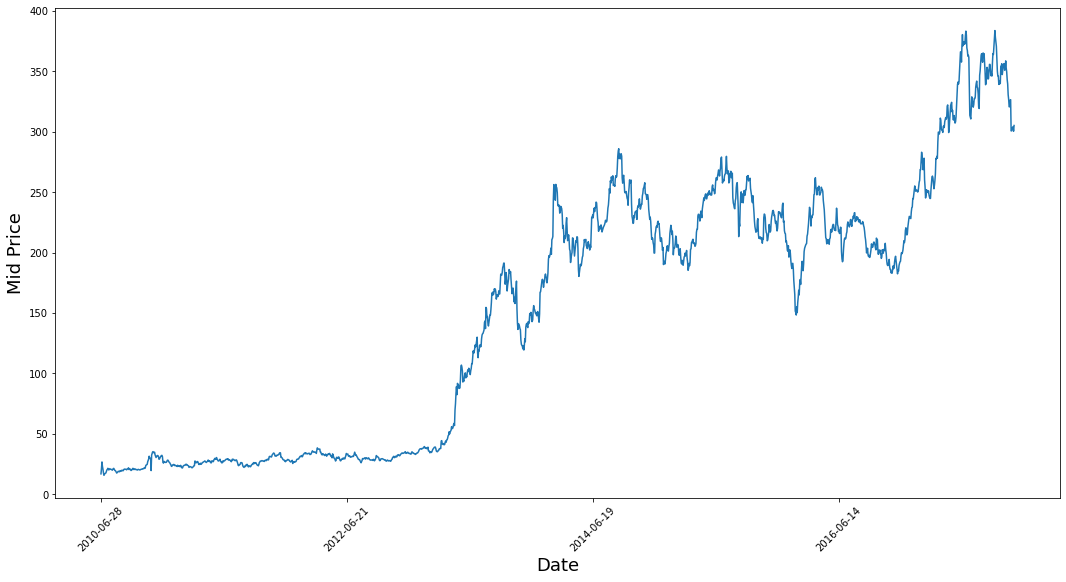

In [192]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [193]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
mid_prices = (high_prices+low_prices)/2.0

# Print to verify data types
print(type(mid_prices))

<class 'pandas.core.series.Series'>


In [194]:
# Split the data into testing and training data
train_data = mid_prices[:1000]
test_data = mid_prices[1000:]
print(train_data)

0       17.000
1       21.270
2       26.860
3       23.095
4       20.905
        ...   
995    206.295
996    204.185
997    215.875
998    229.195
999    228.915
Length: 1000, dtype: float64


In [195]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.values.reshape(-1,1)
test_data = test_data.values.reshape(-1,1)

In [196]:
print(train_data.shape)
print(test_data.shape)

(1000, 1)
(858, 1)


In [197]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 30
for di in range(0,1000,smoothing_window_size):
    train_scaler = scaler.fit(train_data)
    train_scaled = train_scaler.transform(train_data)

# You normalize the last bit of remaining data
scaler.fit(train_data)
train_scaled = train_scaler.transform(train_data)

In [198]:
# Reshape both train and test data
train_scaled = train_data.reshape(-1, 1)

# Normalize test data
test_scaled = scaler.transform(test_data).reshape(-1, 1)

In [199]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(1000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_scaled[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_scaled,test_scaled],axis=0)

In [200]:
window_size = 30
N = train_scaled.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_scaled[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_scaled[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 48.90040


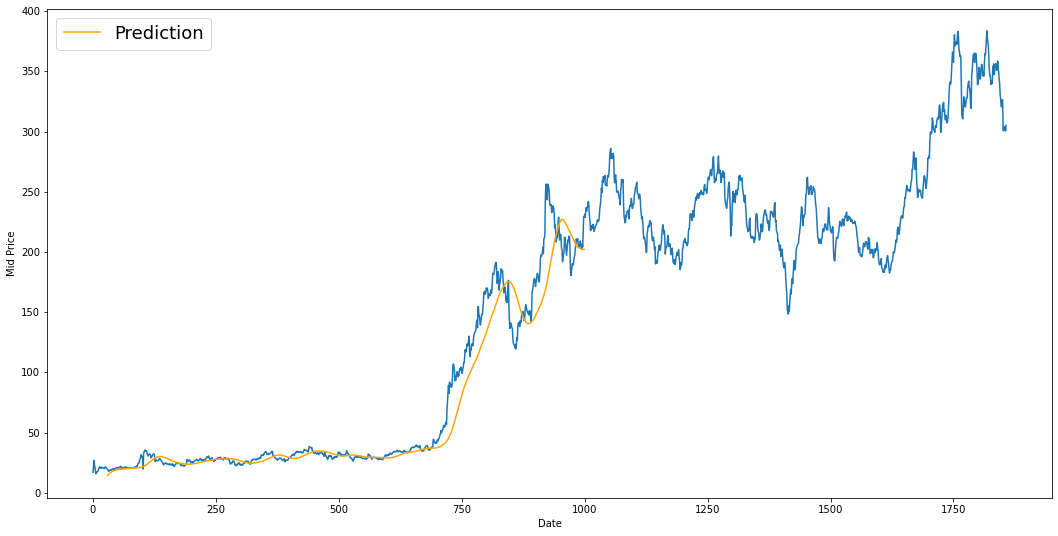

In [201]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [202]:
# Implement Data Generator to train model
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_scaled,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [  1.7       25.126867  27.65506   29.369766 147.56778 ]

	Output: [  1.7       25.168837  27.927498  29.89295  147.56778 ]


Unrolled index 1
	Inputs:  [  3.657     25.139181  27.800552  29.51179  149.54851 ]

	Output: [  9.901096  25.150953  28.078247  29.51179  155.81363 ]


Unrolled index 2
	Inputs:  [  5.9773    25.099262  27.927498  29.696611 151.10666 ]

	Output: [  9.010663  25.131357  28.205423  29.696611 155.81363 ]


Unrolled index 3
	Inputs:  [  7.68907   25.168837  28.078247  29.89295  152.65448 ]

	Output: [  9.010663  25.168837  28.078247  30.000654 152.65448 ]


Unrolled index 4
	Inputs:  [  9.010663  25.150953  28.205423  30.000654 154.39404 ]

	Output: [  9.901096  25.402704  29.167814  30.81423  158.56676 ]


In [203]:
# Define Hyperparameters
from tensorflow.python.framework import ops

D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

ops.reset_default_graph() # This is important in case you run this multiple times

In [204]:
# Defining Inputs and Outputs

# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(ui)
    train_outputs.append(ui)

In [205]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

AttributeError: module 'tensorflow' has no attribute 'contrib'